<a href="https://colab.research.google.com/github/Karnak123/youtube-adview-prediction/blob/main/youtbe_adview_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import relevant libraries

In [ ]:
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from google.colab import files

# Read csv

Manually upload file after downloading from https://drive.google.com/file/d/1Dv-HF10AUUA03AO_cQvar462eXawk0iQ/view

In [ ]:
data = pd.read_csv('train.csv')

# Preprocessing

In [ ]:
categories = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "H": 8}

data["category"] = data["category"].map(categories)

In [ ]:
for e in ["views", "likes", "dislikes", "comment"]:
    data = data[data[e] != "F"]

for e in ["views", "likes", "dislikes", "comment", "adview"]:
    data[e] = pd.to_numeric(data[e])

data = data[data["adview"] < 2000000]

for e in ["published", "vidid"]:
    data[e] = LabelEncoder().fit_transform(data[e])

In [ ]:
def checki(x):
    y = x[2:]
    h, m, s, mm = "", "", "", ""
    P = ["H", "M", "S"]
    for i in y:
        if i not in P:
            mm += i
        else:
            if i == P[0]:
                h = mm
                mm = ""
            elif i == P[1]:
                m = mm
                mm = ""
            else:
                s = mm
                mm = ""
    if h == "":
        h = "00"
    if m == "":
        m = "00"
    if s == "":
        s = "00"
    bp = h + ":" + m + ":" + s
    return bp

In [ ]:
def func_sec(time_str):
    h, m, s = time_str.split(":")
    return int(h) * 3600 + int(m) * 60 + int(s)

In [ ]:
data["duration"] = data["duration"].apply(checki).apply(func_sec)

# Visualize correlation

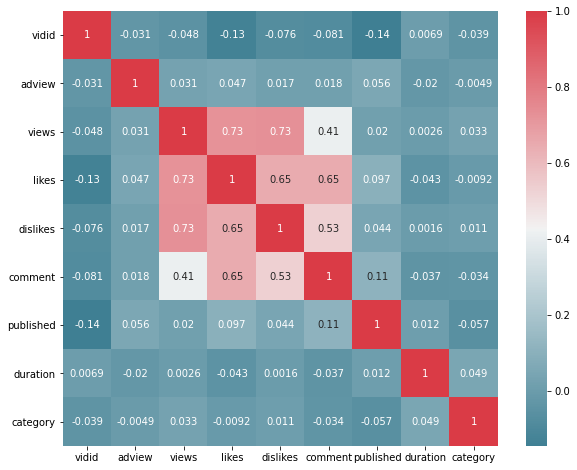

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
square=True, ax=ax,annot=True)
plt.show()

# Prepare for input to model

In [ ]:
Y = pd.DataFrame(data.iloc[:, 1].values, columns=["target"])
data = data.drop(["adview", "vidid"], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data, Y, test_size=0.1, random_state=42
)
y_train = y_train.to_numpy().ravel()
y_test = y_test.to_numpy().ravel()

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Test on models

In [ ]:
def evaluate(X_test, y_test, model):
    y_preds = model.predict(X_test)
    print(y_test[:5], y_preds[:5])
    print("RMSE : ", np.sqrt(mean_squared_error(y_test, y_preds)))
    print("MAE : ", mean_absolute_error(y_test, y_preds))
    print()

### SVR

In [ ]:
svr_model = SVR()
svr_model.fit(X_train, y_train)
print("SVR")
evaluate(X_test, y_test, svr_model)

SVR
[5 2 5 1 2] [4.67394529 1.82824105 1.58383048 2.18837278 1.37217261]
RMSE :  10176.554553901715
MAE :  1046.249824603345



### Decision Tree

In [ ]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
print("Decision Tree")
evaluate(X_test, y_test, dt_model)

Decision Tree
[5 2 5 1 2] [2. 1. 7. 1. 1.]
RMSE :  17313.768066676494
MAE :  2283.7281420765025



### Random Forest

In [ ]:
rf_model = RandomForestRegressor(n_estimators=300)
rf_model.fit(X_train, y_train)
print("Random Forest")
evaluate(X_test, y_test, rf_model)

Random Forest
[5 2 5 1 2] [  7.47        12.71333333   8.74666667   2.42       861.87333333]
RMSE :  13980.065905041802
MAE :  2451.7999203096538



# Save models to colab

In [ ]:
joblib.dump(svr_model, "svr_model.pkl")
joblib.dump(dt_model, "dt_model.pkl")
joblib.dump(rf_model, "rf_model.pkl")

['rf_model.pkl']

# Save models to PC (Chrome only)

In [ ]:
files.download("svr_model.pkl")
files.download("dt_model.pkl")
files.download("rf_model.pkl")